In [16]:
!pip install -q langgraph langsmith langchain langchain_groq langchain_community arxiv wikipedia

In [24]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_groq import ChatGroq
from google.colab import userdata
import os

In [ ]:
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)

arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

In [18]:
print("Wikipedia Results\n")
print('---'*100)
print(wikipedia_tool.invoke('who is henry cavill'))

Wikipedia Results

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Page: Henry Cavill
Summary: Henry William Dalgliesh Cavill ( KAV-əl; born 5 May 1983) is a British actor. He is known for his portrayal of Charles Brandon in Showtime's The Tudors (2007–2010), Superman in the DC Extended Universe (2013–2023), Geralt of Rivia in the Netflix fantasy series The Witcher


In [19]:
print("ARxiv Results\n")
print('---'*100)
arxiv_tool.invoke('speculative rag')

ARxiv Results

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


'Published: 2024-07-11\nTitle: Speculative RAG: Enhancing Retrieval Augmented Generation through Drafting\nAuthors: Zilong Wang, Zifeng Wang, Long Le, Huaixiu Steven Zheng, Swaroop Mishra, Vincent Perot, Yuwei Zhang, Anush Mattapalli, Ankur Taly, Jingbo Shang, Chen-Yu Lee, Tomas Pfister\nSummary: Retrie'

In [20]:
tools = [wikipedia_tool,arxiv_tool]

In [21]:
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages:Annotated[list,add_messages]

In [23]:
from langgraph.graph import StateGraph,START,END

graph_builder = StateGraph(State)

In [25]:
os.environ['GROQ_API_KEY'] = userdata.get("GROQ_API_KEY")

In [26]:
llm = ChatGroq(model_name="Gemma2-9b-It")

In [28]:
llm_with_tools = llm.bind_tools(tools=tools)

In [30]:
def chatbot(state:State):
  return {'messages':[llm_with_tools.invoke(state['messages'])]}

In [31]:
from langgraph.prebuilt import ToolNode,tools_condition

In [32]:
graph_builder.add_node('chatbot',chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node('tools',tool_node)

graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
    )
graph_builder.add_edge('tools','chatbot')
graph_builder.add_edge(START,'chatbot')

In [33]:
graph = graph_builder.compile()

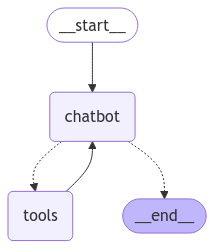

In [35]:
from IPython.display import Image,display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [42]:
you = 'What is ai?'

events = graph.stream(
    {'messages': [('user',you)]},stream_mode='values'
)
for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

What is ai?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_45bs)
 Call ID: call_45bs
  Args:
    query: artificial intelligence
================================= Tool Message =================================
Name: wikipedia

Page: Artificial intelligence
Summary: Artificial intelligence (AI), in its broadest sense, is intelligence exhibited by machines, particularly computer systems. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their enviro
================================== Ai Message ==================================

Artificial intelligence (AI), in its broadest sense, is intelligence exhibited by machines, particularly computer systems. It is a field of research in computer science that develops and studies methods and software that enable machines to perce